-Added 2 layers to autoencoder
-changed img input

In [ ]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
from sklearn.neighbors import KernelDensity
import random
import shutil

import glob

In [ ]:
% matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls   #check if mounted correctly

DATADIR = "/content/gdrive/My Drive/pc_stress_test"
os.listdir('/content/gdrive/My Drive/pc_stress_test')     #show directories in base directory

Mounted at /content/gdrive
gdrive	sample_data


['idle', 'gpu_stress', 'motherboard_stress', 'train', 'val', 'test']

In [ ]:
Classes = ["1SX", "2OH", "3MF", "4CF", "5EB"]

In [ ]:
for cl in Classes:
  img_path = os.path.join(DATADIR, cl)    # Merge DATADIR with class name
  print(img_path)
  images = glob.glob(img_path + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
  print("{}: {} Images". format(cl,len(images)))
  num_train = int(round(len(images)*0.7))     # Find what 70% of images is
  num_val	= int(round(len(images)*0.9))
  train, val, test = images[:num_train], images[num_train:num_val], images[num_val:]   # Assign 70%, 20% and 10% of images to training, validation and test datasets respectively. list starting at index 0 up to but not including num_train

  for t in train:
    if not os.path.exists(os.path.join(DATADIR, 'train', cl)):
      os.makedirs(os.path.join(DATADIR, 'train', cl))
    shutil.move(t, os.path.join(DATADIR, 'train', cl))      # Move images to train directory

  for v in val:
    if not os.path.exists(os.path.join(DATADIR, 'val', cl)):
      os.makedirs(os.path.join(DATADIR, 'val', cl))
    shutil.move(v, os.path.join(DATADIR, 'val', cl))        #Move images to val directory

  for te in test:
    if not os.path.exists(os.path.join(DATADIR, 'test', cl)):
      os.makedirs(os.path.join(DATADIR, 'test', cl))
    shutil.move(te, os.path.join(DATADIR, 'test', cl))      # Move images to train directory


/content/gdrive/My Drive/thermal_image_black_label/1SX
1SX: 179 Images
/content/gdrive/My Drive/thermal_image_black_label/2OH
2OH: 180 Images
/content/gdrive/My Drive/thermal_image_black_label/3MF
3MF: 268 Images
/content/gdrive/My Drive/thermal_image_black_label/4CF
4CF: 270 Images
/content/gdrive/My Drive/thermal_image_black_label/5EB
5EB: 269 Images


In [ ]:
batch_size = 32
IMG_width = 256
IMG_height= 256

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/pc_stress_test/train/idle_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/pc_stress_test/val/idle_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'      #Use for Autoencoders because there is one class, its input and output
    )

anomaly_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/pc_stress_test/val/motherboard_stress_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )

images = glob.glob('/content/gdrive/My Drive/thermal_image_black_label/train/4CF_autoencoder/4CF' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('4CF_autoencoder_train',len(images)))

images = glob.glob('/content/gdrive/My Drive/thermal_image_black_label/val/4CF_autoencoder/4CF' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('4CF_autoencoder_val',len(images)))

images = glob.glob('/content/gdrive/My Drive/thermal_image_black_label/train/5EB_autoencoder/5EB' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('5EB_autoencoder',len(images)))

# help(ImageDataGenerator)

Found 700 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
4CF_autoencoder_train: 189 Images
4CF_autoencoder_val: 54 Images
5EB_autoencoder: 188 Images


In [ ]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(IMG_height, IMG_width, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding='same')) # using pool_size (2,2) makes the layer 2x smaller in height and width

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(16,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))
#-------------------------

model.summary()

# Compile the model
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=1e-3, decay=1e-3 / 600)
model.compile(optimizer=opt, loss='mean_squared_error')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 3)         219       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 3)        

In [ ]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) # Early stopping (stops training when validation doesn't improve for {patience} epochs).  min_delta=1 to abort if improvement is less than 1%. verbose displayes last epoch
model_filepath = 'models/model1.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
model.fit(
        train_generator,        #add accuracy metric
        steps_per_epoch=int(np.ceil(train_generator.n / float(batch_size))),
        epochs=2,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(validation_generator.n / float(batch_size))),
        shuffle = True,
        callbacks=[es, save_best])

Epoch 1/2
22/22 [==============================] - 84s 4s/step - loss: 0.0061 - val_loss: 0.0064
Epoch 2/2
22/22 [==============================] - 82s 4s/step - loss: 0.0061 - val_loss: 0.0063


In [ ]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model(model_filepath)

In [ ]:
model_filepath      #check model name

'models/model1.keras'

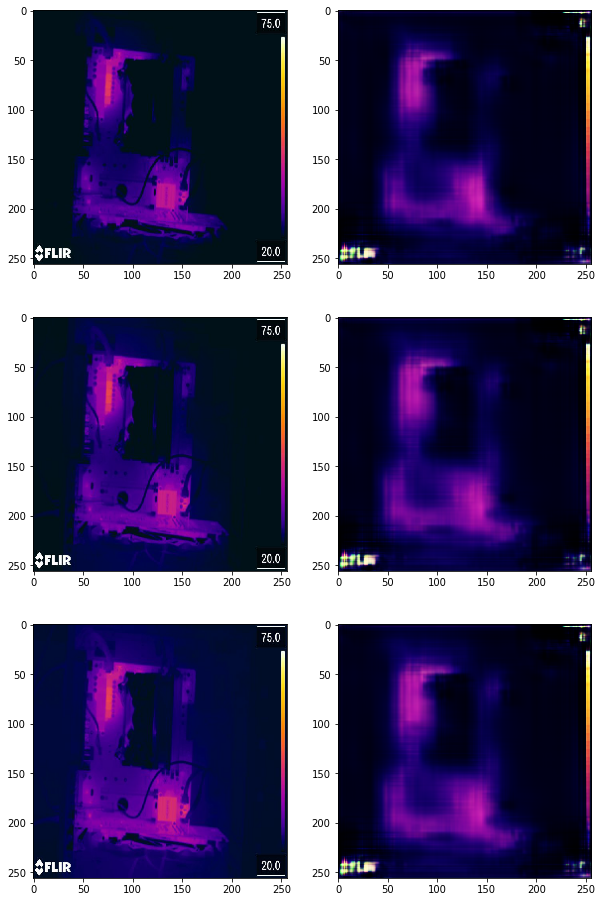

In [ ]:
# Test the model by viewing a sample of original and reconstructed images of training dataset 
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 3     #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

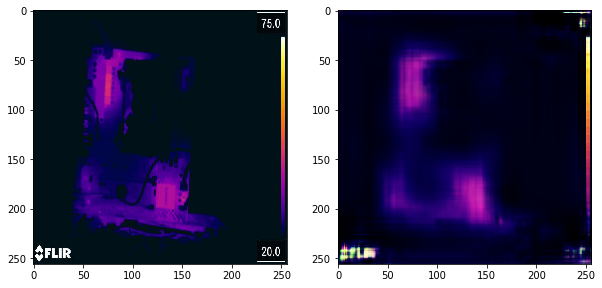

In [ ]:
# Test the model by viewing a sample of original and reconstructed images of validation dataset
data_list = []
batch_index = 0
while batch_index <= validation_generator.batch_index:
    data = validation_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 1     #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

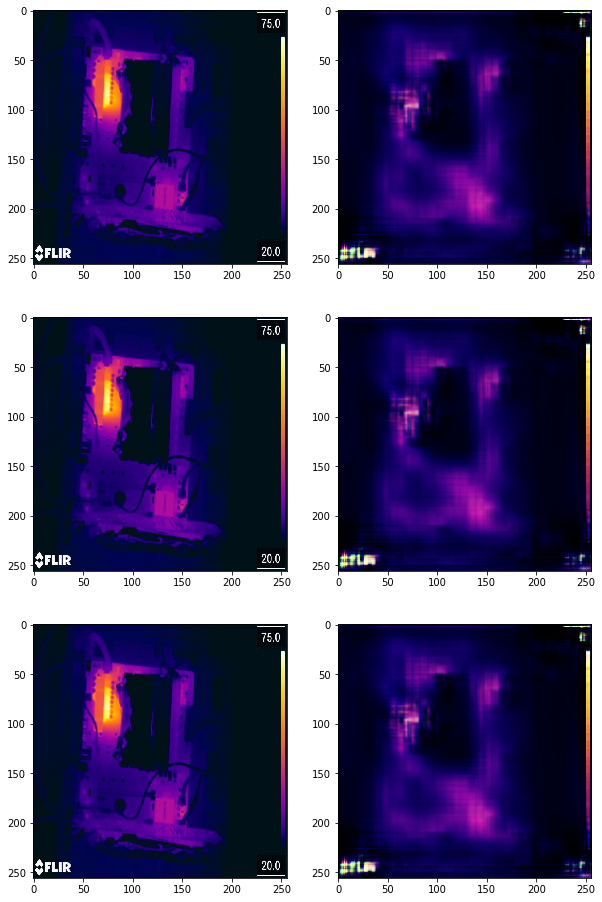

In [ ]:
# Test the model by viewing a sample of original and reconstructed images of anomaly dataset
data_list = []
batch_index = 0
while batch_index <= anomaly_generator.batch_index:
    data = anomaly_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 3     #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [ ]:

# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate(validation_generator)}, error on anomaly set:{model.evaluate(anomaly_generator)}")

7/7 [==============================] - 8s 1s/step - loss: 0.0139
Error on validation set:0.006307286210358143, error on anomaly set:0.013928265310823917


In [ ]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 96x96x3 and compresses it down to a 3x3x3 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(IMG_height, IMG_width, 3), weights=model.layers[0].get_weights()) )    #get weights from original model
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.add(Conv2D(8,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[4].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[6].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 3)         219       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 3)        

In [ ]:
# Creating encoded (compressed versions of the training, validation and anomalous images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder
encoded_images = encoder_replica.predict(train_generator)
encoded_images_flat = [np.reshape(img, (768)) for img in encoded_images]      #to get the second argument multiply the dimensions in encoded_images: 12*12*3=432. Do this to flatten image

validation_encoded = encoder_replica.predict(validation_generator)
val_enc_flat = [np.reshape(img, (768)) for img in validation_encoded]

anom_encoded = encoder_replica.predict(anomaly_generator)
anom_enc_flat = [np.reshape(img, (768)) for img in anom_encoded]

526.5197720701988
[527.03595105 527.54552495 526.92497786 527.85192957 525.60174035
 526.79571621 526.37247155 527.19101529 526.49392325 525.4694529
 527.59977889 524.89513822 525.37213406 525.35346097 526.72354241
 524.58269228 527.82100042 527.24026172 527.95182984 524.88088265
 526.3586139  523.85058155 527.92488574 525.16852611 527.79286538
 524.62928072 526.9011175  526.12029048 523.81343736 525.8984231
 527.32199823 525.31466887 526.02607896 526.31168211 526.67146626
 526.76317584 525.35532519 527.79735962 523.75244299 527.65455839
 527.02178486 527.10641996 525.32438875 525.50404742 527.98759545
 523.82649056 525.63479805 524.50652434 525.94955036 524.90240247
 527.23495605 526.01922178 525.9018569  527.95419238 526.19921127
 527.76401371 525.15325091 525.47451998 524.81825297 527.95951366
 524.45814553 525.26879987 526.87570956 525.42656328 523.79600201
 525.02081224 526.67367268 527.38697906 524.29504972 526.93914766
 526.39220199 527.76387386 525.17942514 527.19832231 524.352

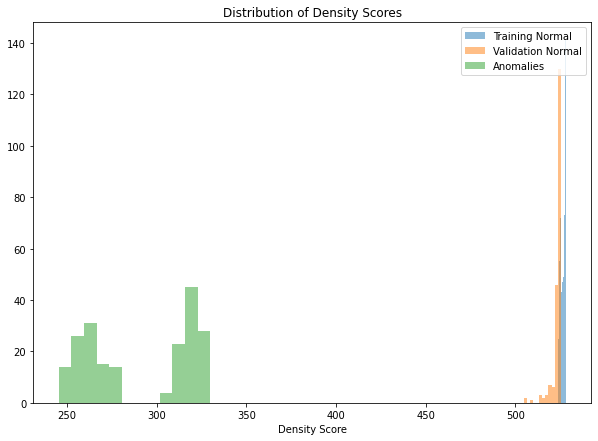

In [ ]:

# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)        # kernel density is a tool used to make discrete values smooth. bandwidth is how smooth it is. kernel is the function used. check https://mathisonian.github.io/kde/
training_density_scores = kde.score_samples(encoded_images_flat) 
print(np.median(training_density_scores))
print(training_density_scores)

validation_density_scores = kde.score_samples(val_enc_flat)
print(np.median(validation_density_scores))
print(validation_density_scores)

anomaly_density_scores = kde.score_samples(anom_enc_flat)
print(np.median(anomaly_density_scores))
print(anomaly_density_scores)



# Plotting the density distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(validation_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(anomaly_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

In [ ]:
# Create a function for classifying images in bulk (for testing purposes)
def get_mse(original, reconstruction):
    # Returns the mean square error for each image in the array
    return np.mean((original - reconstruction)**2, axis=(1,2,3)) 

def evaluate_model(test_file):
    density_threshold = 500 # This threshold was chosen based on looking at the distribution of the density scores of the normal class (validation set)
    reconstruction_error_threshold = 0.030 # This threshold was chosen based on looking at the distribution of reconstruction errors of the normal class
    batch_size  = 0
    for (dirpath, dirnames, filenames) in os.walk(test_file):
        batch_size += len([file for file in filenames if file.endswith(".jpg")]) # Batchsize now is total images in folder
    
    test_img_generator = test_datagen.flow_from_directory(
    test_file,
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )
    
    images = test_img_generator.next()[0]   #load test images to variable images
    reconstructions = model.predict(images) #get reconstructed images
    MSEs = get_mse(images, reconstructions) #get mse
    reconstruction_anomalies = MSEs > reconstruction_error_threshold
    print(f'Reconstruction anomalies = {sum(reconstruction_anomalies)}')
    
    encoded_images = encoder_replica.predict(test_img_generator)
    print('hi')
    encoded_images_flat = np.array([np.reshape(img, (768)) for img in encoded_images])        #change argument
    density_scores = kde.score_samples(encoded_images_flat)
    density_anomalies = density_scores < density_threshold
    
    combined_anomalies = np.maximum(reconstruction_anomalies, density_anomalies)
    print(f'Combined anomalies = {sum(combined_anomalies)}')
    overall_detection_rate = sum(combined_anomalies) / len(combined_anomalies)
    print(f'Overall detection rate = {overall_detection_rate}')
    return  MSEs

In [ ]:
# Check what proportion of normal validation images get classified as anomalous
MSE_normal=evaluate_model('/content/gdrive/My Drive/pc_stress_test/train/idle_autoencoder')

Found 700 images belonging to 1 classes.
Reconstruction anomalies = 0
hi
Combined anomalies = 0
Overall detection rate = 0.0


In [ ]:
# Check what proportion of normal images get classified as anomalous
MSE_val=evaluate_model('/content/gdrive/My Drive/pc_stress_test/val/motherboard_stress_autoencoder')

Found 200 images belonging to 1 classes.
Reconstruction anomalies = 0
hi
Combined anomalies = 200
Overall detection rate = 1.0


In [ ]:
# Check what proportion of anomaly images (a set which was unseen in training) get classified as anomalous
MSE_anom=evaluate_model('/content/gdrive/My Drive/pc_stress_test/val/idle_autoencoder')

Found 200 images belonging to 1 classes.
Reconstruction anomalies = 0
hi
Combined anomalies = 0
Overall detection rate = 0.0


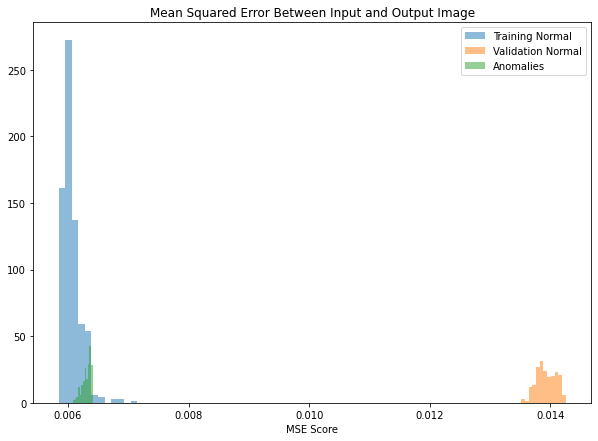

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Mean Squared Error Between Input and Output Image')
plt.hist(MSE_normal, 12, alpha=0.5, label='Training Normal')
plt.hist(MSE_val, 12, alpha=0.5, label='Validation Normal')
plt.hist(MSE_anom, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('MSE Score')

plt.show()